In [0]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/AIML/Project_Plant_Breed')

In [4]:
ls

test_data.zip  train_data.zip


In [0]:
from zipfile import ZipFile
with ZipFile('train_data.zip', 'r') as z:
  z.extractall()

In [0]:
from zipfile import ZipFile
with ZipFile('test_data.zip', 'r') as z:
  z.extractall()

In [0]:
x_test=[]
os.chdir('/content/drive/My Drive/AIML/Project_Plant_Breed/test')
import cv2
for i in os.listdir():
    dummy = cv2.imread(i)
    dummy = cv2.resize(dummy,(128,128))
    x_test.append(dummy)

In [0]:
os.chdir('/content/drive/My Drive/AIML/Project_Plant_Breed/train')

In [14]:
x_train = []
y_train = []
import cv2
for i in os.listdir():
    print(i)
    if (os.path.isdir(i)):
            for j in os.listdir(i):
                try:
                    dummy = cv2.imread('/content/drive/My Drive/AIML/Project_Plant_Breed/train/' + i + "/" + j)
                    dummy = cv2.resize(dummy,(128,128))
                    x_train.append(dummy)
                    y_train.append(i)
                except Exception as e:
                    print(e)

Fat Hen
Small-flowered Cranesbill
Cleavers
Black-grass
Sugar beet
Shepherds Purse
Charlock
Loose Silky-bent
Scentless Mayweed
Maize
Common Chickweed
Common wheat


In [15]:
import numpy as np # MATRIX OPERATIONS
import pandas as pd # EFFICIENT DATA STRUCTURES
import matplotlib.pyplot as plt # GRAPHING AND VISUALIZATIONS
import math # MATHEMATICAL OPERATIONS
import cv2 # IMAGE PROCESSING - OPENCV
from glob import glob # FILE OPERATIONS
import itertools

# KERAS AND SKLEARN MODULES
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# GLOBAL VARIABLES
scale = 70
seed = 7

Using TensorFlow backend.


In [0]:
trainingset = []
traininglabels = []

trainingset = np.asarray(x_train)
traininglabels = pd.DataFrame(y_train)

In [17]:
trainingset.shape

(4750, 128, 128, 3)

In [18]:
traininglabels.shape

(4750, 1)

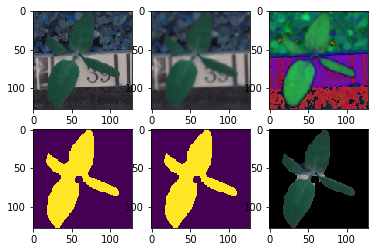

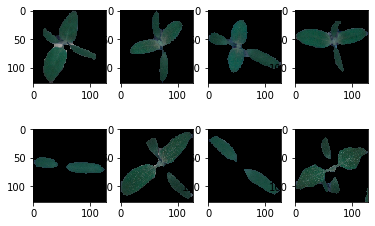

In [19]:
#Cleaning the images and removing the background:

new_train = []
sets = []; getEx = True
for i in trainingset:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    #GREEN PARAMETERS
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    new = np.zeros_like(i,np.uint8)
    new[boolean] = i[boolean]
    new_train.append(new)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i) # ORIGINAL
        plt.subplot(2,3,2);plt.imshow(blurr) # BLURRED
        plt.subplot(2,3,3);plt.imshow(hsv) # HSV CONVERTED
        plt.subplot(2,3,4);plt.imshow(mask) # MASKED
        plt.subplot(2,3,5);plt.imshow(boolean) # BOOLEAN MASKED
        plt.subplot(2,3,6);plt.imshow(new) # NEW PROCESSED IMAGE
        plt.show()
        getEx = False
new_train = np.asarray(new_train)

# CLEANED IMAGES
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(new_train[i])

Classes['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
12


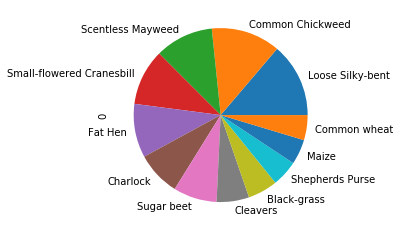

In [20]:
# Converting the Labels into numbers:

labels = preprocessing.LabelEncoder()
labels.fit(traininglabels[0])
print('Classes'+str(labels.classes_))
encodedlabels = labels.transform(traininglabels[0])
clearalllabels = np_utils.to_categorical(encodedlabels)
classes = clearalllabels.shape[1]
print(str(classes))
traininglabels[0].value_counts().plot(kind='pie')

In [0]:
# Defining our model and splitting the dataset to train and validate :

new_train = new_train/255
x_train,x_test,y_train,y_test = train_test_split(new_train,clearalllabels,test_size=0.1,random_state=seed,stratify=clearalllabels)

In [0]:
# To prevent overfitting, we need to create a function that can randomly change image characterisitics during fitting.

generator = ImageDataGenerator(rotation_range = 180,zoom_range = 0.1,width_shift_range = 0.1,height_shift_range = 0.1,horizontal_flip = True,vertical_flip = True)
generator.fit(x_train)

In [23]:
# Defining the Convolutional Neural Network:
# This model has 4 convolution layers and 3 fully connected layers.

np.random.seed(seed)

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(5, 5), input_shape=(scale, scale, 3), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(BatchNormalization(axis=3))
model.add(Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization(axis=3))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 66, 66, 64)        4864      
_________________________________________________________________
batch_normalization_1 (Batch (None, 66, 66, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 62, 64)        102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 31, 31, 64)        256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0 

In [30]:
## Fitting the CNN onto the data:
## Note -- 
#We have to reduce the learning rate because, convergence will be much quicker.
#We have to save the best weights of the model.
#We have to save the last weights of the model.


# SETTING UP CHECKPOINTS, CALLBACKS AND REDUCING LEARNING RATE
lrr = ReduceLROnPlateau(monitor='val_acc', 
                        patience=3, 
                        verbose=1, 
                        factor=0.4, 
                        min_lr=0.00001)

filepath="/content/drive/My Drive/AIML/Project_Plant_Breed/weights.best_{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
filepath="/content/drive/My Drive/AIML/Project_Plant_Breed/weights.last_auto4.hdf5"
checkpoints_full = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')

callbacks_list = [checkpoints, lrr, checkpoints_full]

#MODEL
# hist = model.fit_generator(datagen.flow(trainX, trainY, batch_size=75), 
#                            epochs=35, validation_data=(testX, testY), 
#                            steps_per_epoch=trainX.shape[0], callbacks=callbacks_list)

# LOADING MODEL
model.load_weights("/content/drive/My Drive/AIML/Project_Plant_Breed/weights.best_17-0.96.hdf5")
dataset = np.load("/content/drive/My Drive/AIML/Project_Plant_Breed/Data.npz")
data = dict(zip(("x_train","x_test","y_train", "y_test"), (dataset[k] for k in dataset)))
x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']

print(model.evaluate(x_train, y_train))  # Evaluate on train set
print(model.evaluate(x_test, y_test))  # Evaluate on test set

4275/4275 [==============================] - 111s 26ms/step
[0.0014231704439086374, 0.99953216374269]
475/475 [==============================] - 12s 26ms/step
[0.27398815355018563, 0.9621052635343451]


In [31]:
# CONFUSION MATRIX
y_pred = model.predict(x_test)
y_class = np.argmax(y_pred, axis = 1) 
y_check = np.argmax(y_test, axis = 1) 

cmatrix = confusion_matrix(y_check, y_class)
print(cmatrix)

[[19  0  0  0  0  0  7  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  1  0  0]
 [ 0  0 28  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 60  0  0  0  0  0  1  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 47  0  0  0  0  0  0]
 [ 5  0  0  0  0  0 60  0  0  0  0  0]
 [ 0  0  0  0  0  1  0 21  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0  0  1 22  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 39]]


In [36]:
path_to_test = '/content/drive/My Drive/AIML/Project_Plant_Breed/test/*.png'
pics = glob(path_to_test)

testimages = []
tests = []
count=1
num = len(pics)

for i in pics:
    print(str(count)+'/'+str(num),end='\r')
    tests.append(i.split('/')[-1])
    testimages.append(cv2.resize(cv2.imread(i),(scale,scale)))
    count = count + 1

testimages = np.asarray(testimages)

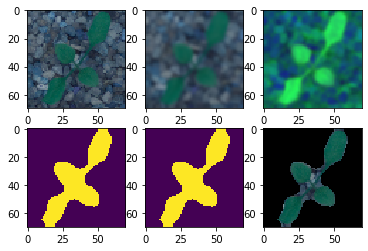

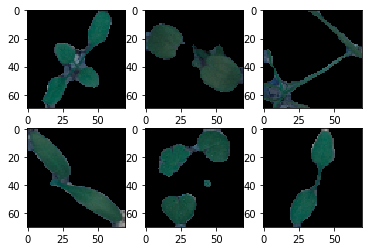

In [37]:
newtestimages = []
sets = []
getEx = True
for i in testimages:
    blurr = cv2.GaussianBlur(i,(5,5),0)
    hsv = cv2.cvtColor(blurr,cv2.COLOR_BGR2HSV)
    
    lower = (25,40,50)
    upper = (75,255,255)
    mask = cv2.inRange(hsv,lower,upper)
    struc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
    mask = cv2.morphologyEx(mask,cv2.MORPH_CLOSE,struc)
    boolean = mask>0
    masking = np.zeros_like(i,np.uint8)
    masking[boolean] = i[boolean]
    newtestimages.append(masking)
    
    if getEx:
        plt.subplot(2,3,1);plt.imshow(i)
        plt.subplot(2,3,2);plt.imshow(blurr)
        plt.subplot(2,3,3);plt.imshow(hsv)
        plt.subplot(2,3,4);plt.imshow(mask)
        plt.subplot(2,3,5);plt.imshow(boolean)
        plt.subplot(2,3,6);plt.imshow(masking)
        plt.show()
        getEx=False

newtestimages = np.asarray(newtestimages)
# OTHER MASKED IMAGES
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(newtestimages[i])

In [0]:
newtestimages=newtestimages/255
prediction = model.predict(newtestimages)
# PREDICTION TO A CSV FILE
pred = np.argmax(prediction,axis=1)
predStr = labels.classes_[pred]
result = {'file':tests,'species':predStr}
result = pd.DataFrame(result)
result.to_csv("Prediction.csv",index=False)